# Проект для ООО "Так закаляем сталь"

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. **Нам предстоит построить модель, которая предскажет температуру стали.**

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 


Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).


Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.


Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor

## Первичный анализ данных

### Для начала выгрузим данные. 

In [2]:
# данные об электродах
arc = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv')

#данные о подаче сыпучих материалов (объём)
bulk = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')

#данные о подаче сыпучих материалов (время)
bulk_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')

#данные о проволочных материалах (объём)
wire = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')

#данные о проволочных материалах (время)
wire_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')

#данные о продувке сплава газом
gas = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')

#результаты измерения температуры
temp = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv')

### Рассмотрим каждый датасет отдельно, ознакомимся с данными и их особенностями.

## 1. data_arc_new.csv

In [3]:
arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543


Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами.

Первые 2 столбца (столбец `key` в расчет не берем) поясняют во сколько начался нагрев стали и во сколько закончился соответственно. По этим столбам можно узнать продолжительность нагрева.

Активная мощность — среднее значение мгновенной мощности за период нагрева.

Реактивная мощность представляет собой энергию, которая переходит от источника к реактивным элементам приемника, после чего возвращается назад к источнику в период одного колебания.

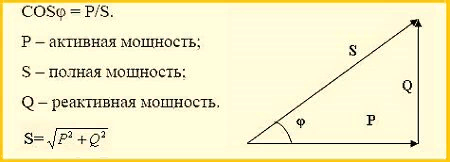

In [4]:
arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


**Пропусков в данных не наблюдается.**

Каждая партия может проходить несколько итераций обработки. Посмотрим число партий, чтобы знать с каким объемом данных работаем.

In [5]:
arc['key'].nunique()

3214

**В предоставленных данных 3214 партий стали.**

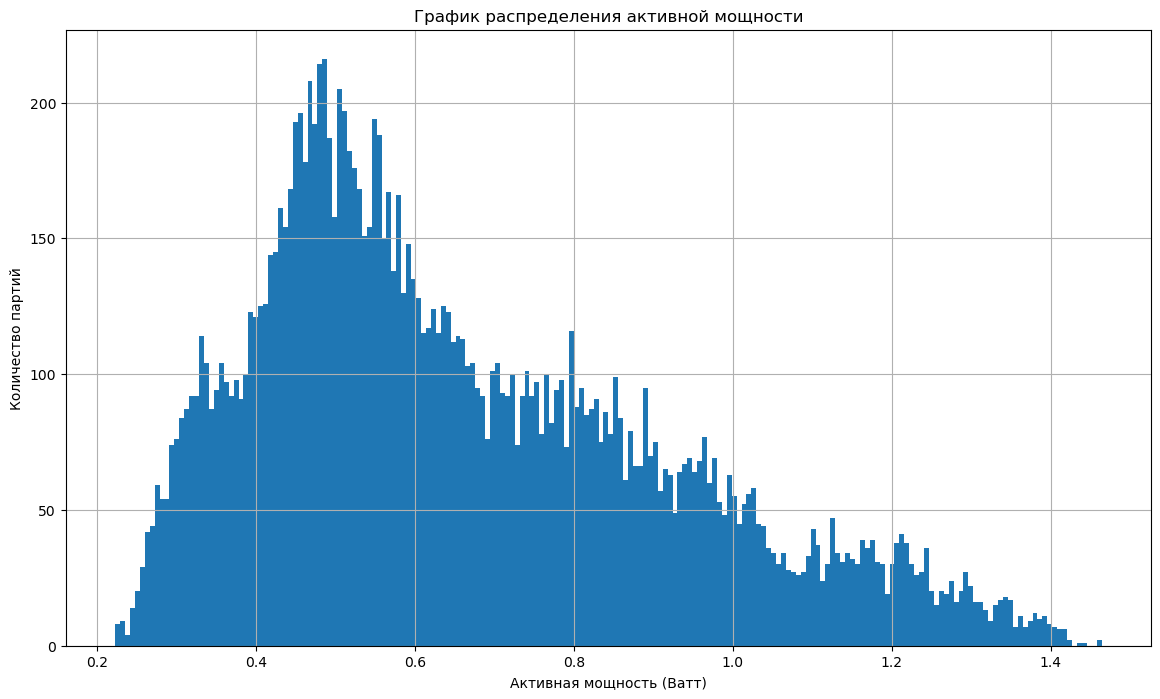

In [6]:
arc['Активная мощность'].hist(figsize=(14,8), bins=200);
plt.xlabel('Активная мощность (Ватт)');
plt.ylabel('Количество партий');
plt.title('График распределения активной мощности');

**Судя по гистограмме распределения активной мощности, оно выглядит нормальным. В основном, среднее значение мгновенной мощности за период нагрева колеблется в пределах 0.3-0.8 ед.** 

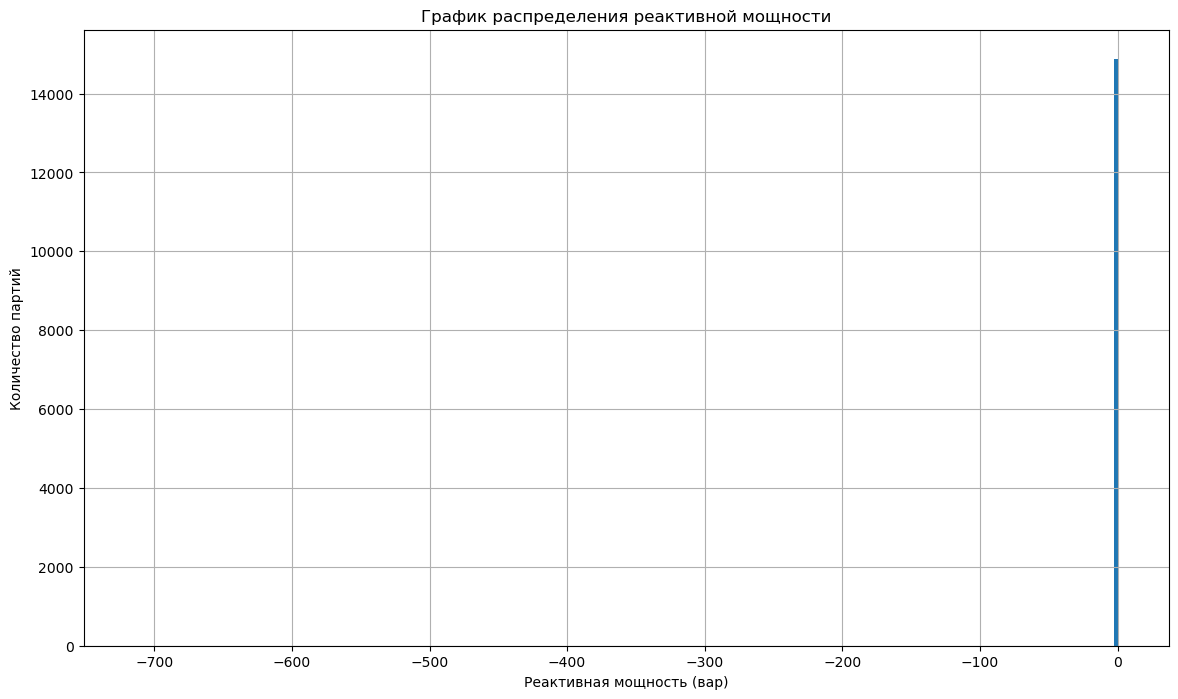

In [7]:
arc['Реактивная мощность'].hist(figsize=(14,8), bins=200);
plt.xlabel('Реактивная мощность (вар)');
plt.ylabel('Количество партий');
plt.title('График распределения реактивной мощности');

Данный график отображается некорректно, так как в данных присутствуют аномально низкие значения (менее -700). Посмотрим поподробнее. 

In [8]:
arc['Реактивная мощность'].describe()

count    14876.000000
mean         0.438986
std          5.873485
min       -715.479924
25%          0.337175
50%          0.441639
75%          0.608201
max          1.270284
Name: Реактивная мощность, dtype: float64

**Мы выявили первую аномалию в данных.** Двигаемся дальше.

## 2. data_bulk_new.csv

In [9]:
bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


На данном этапе изменяют состав стали, добавляя сыпучие материалы.

Столбцы `Bulk 1-15` перечисляют сыпучие материалы, у каждого свой номер. Значения - объемы данного материала, добавленные в сталь.

Значения `NaN` - данный сыпучий материал не добавлялся в смесь.

In [10]:
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


В данном фрейме количество пропусков для нас не важно, их мы уже объяснили.

Количество строк в данных - 3129, что меньше количества партий в наших данных (`key`.nunique()=3214). Скорее всего некоторые партии изначально вышли удачными и не потребовали коррекции. 

In [11]:
bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [12]:
bulk.duplicated().sum()

0

**С первого взгляда в данных нет никаких особенностей. Некоторые материалы добавляют чаще, чем другие. Также в разных пропорциях.**

Построим гистограммы, чтобы визуализировать данные и подтвердить либо опровергнуть выводы. Визуализировать будем наиболее часто добавляемые материалы.

In [13]:
def visual(data):
    data.hist(figsize=(14,8), bins=70, legend=True);
    plt.xlabel('Объем добавленного материала');
    plt.ylabel('Количество партий');
    plt.title('Объемы добавленного материала на стадии коррекции');

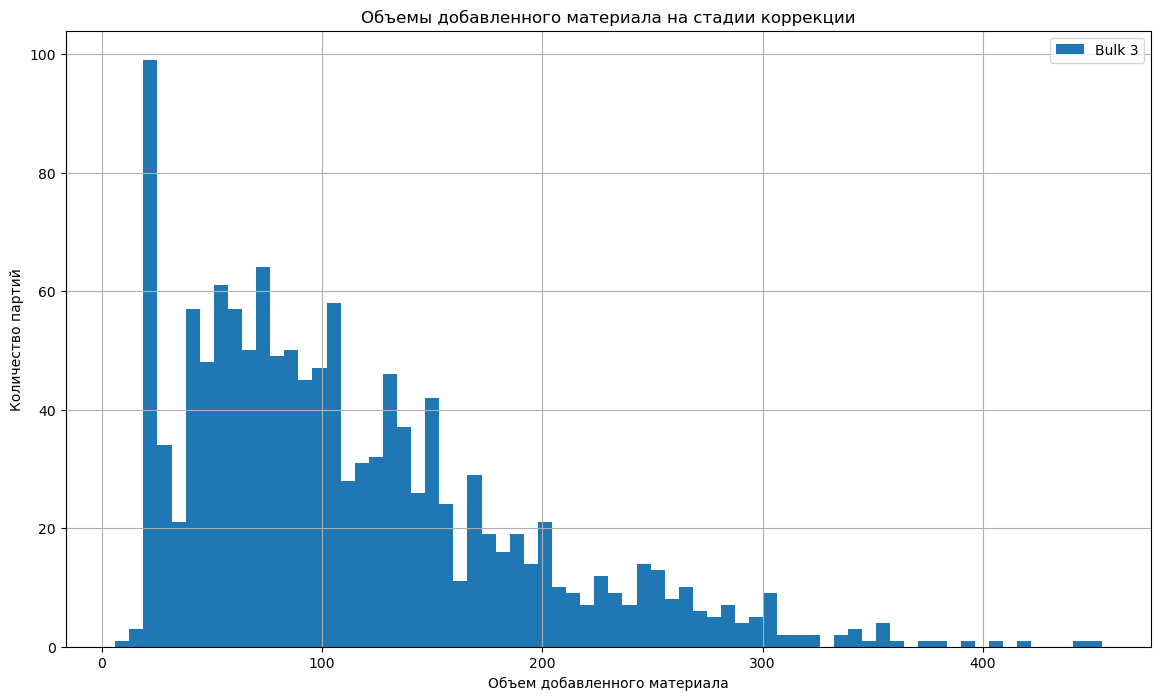

In [14]:
visual(bulk['Bulk 3'])

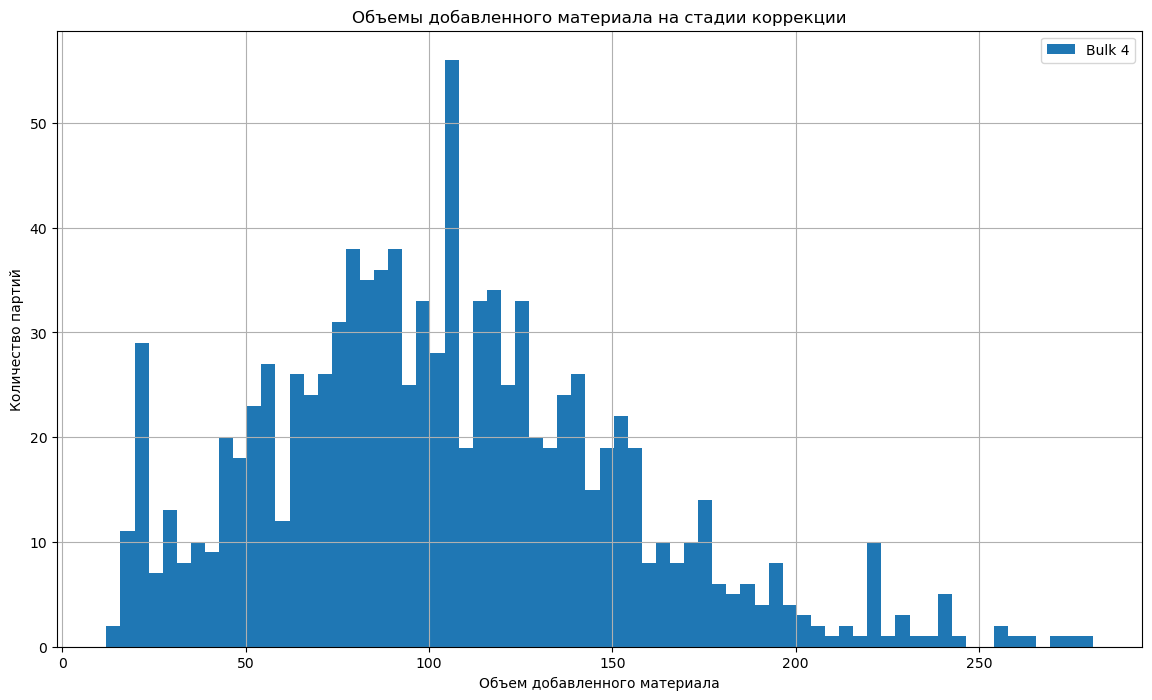

In [15]:
visual(bulk['Bulk 4'])

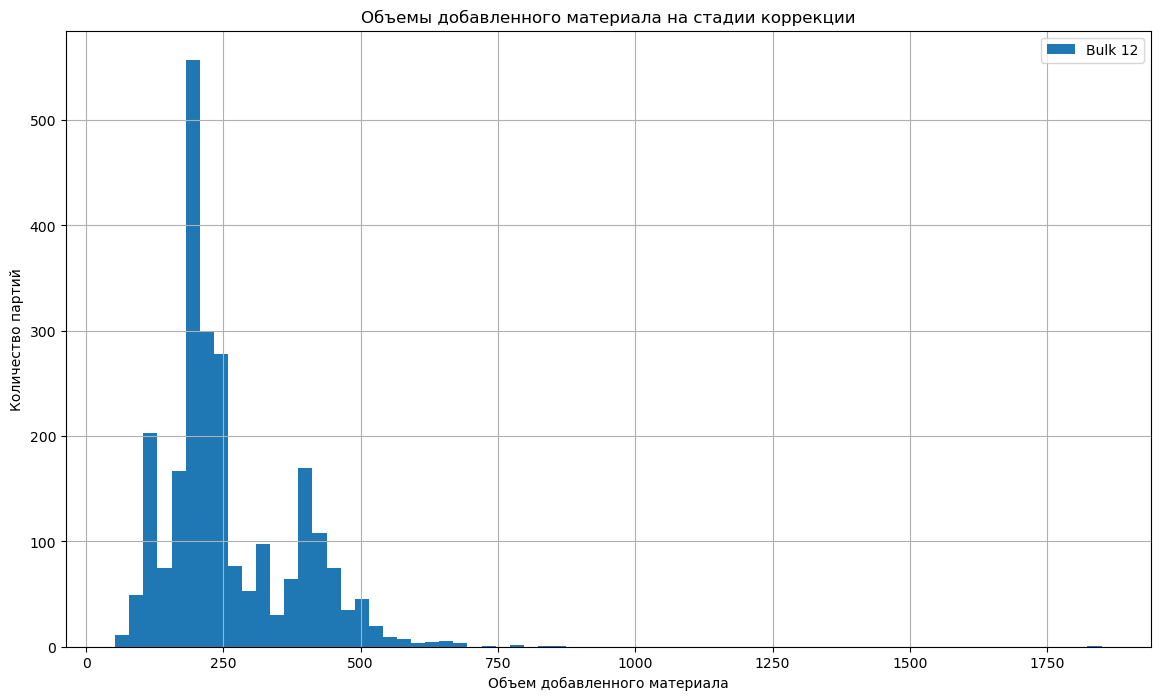

In [16]:
visual(bulk['Bulk 12'])

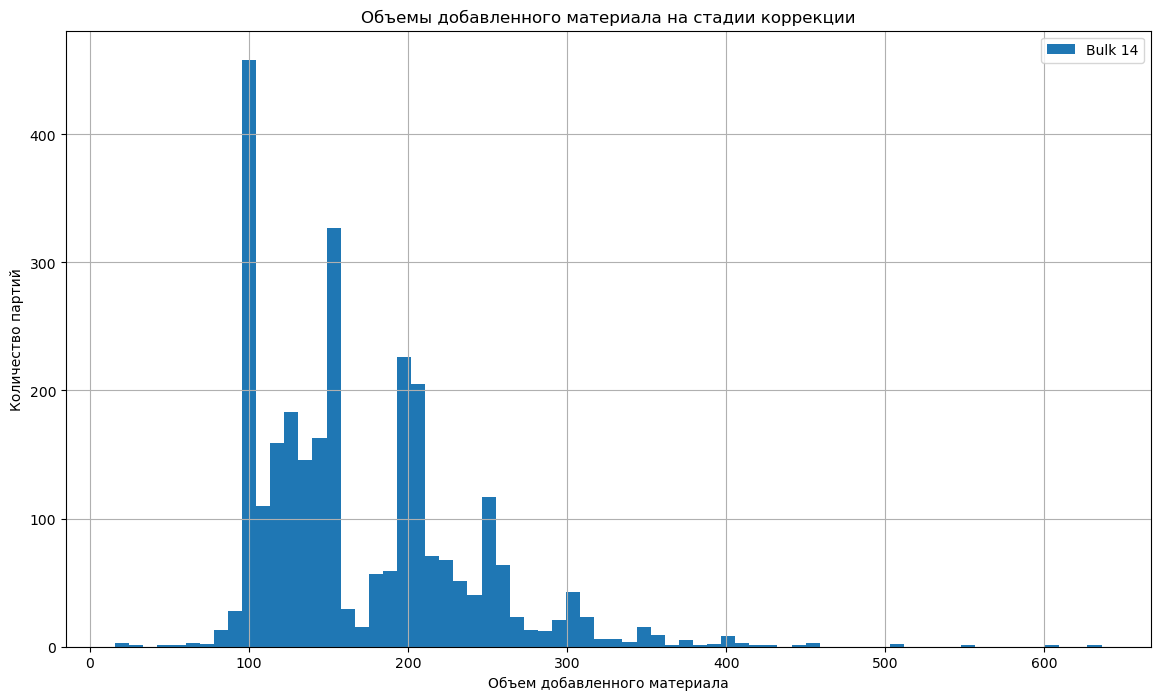

In [17]:
visual(bulk['Bulk 14'])

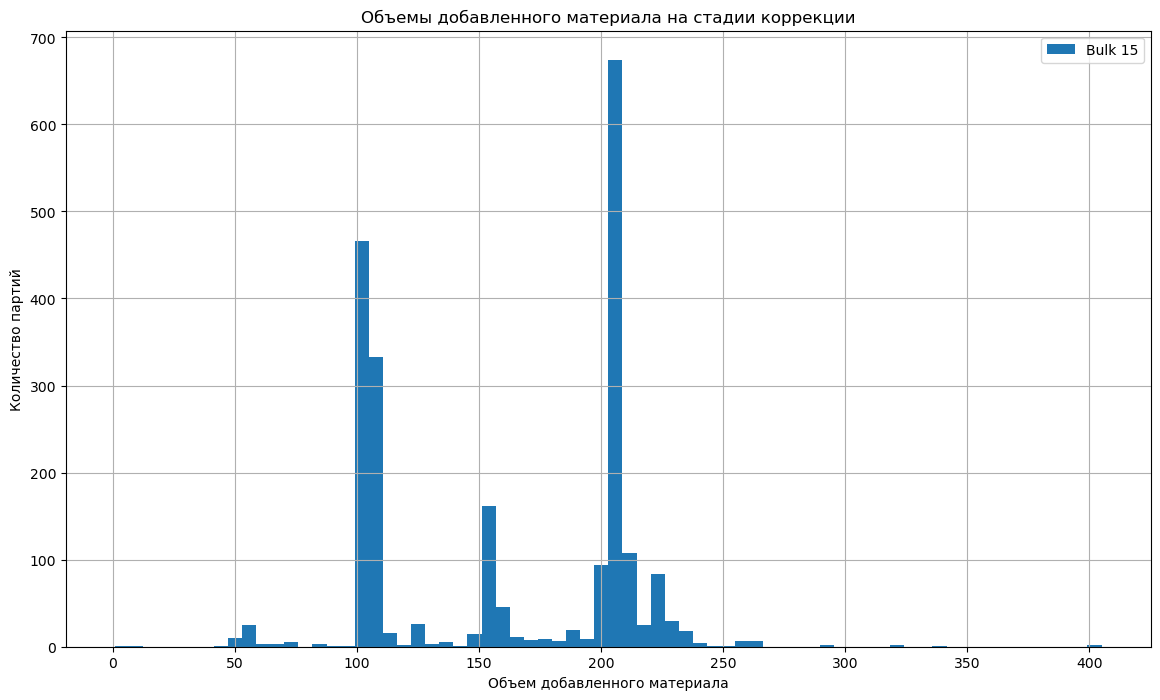

In [18]:
visual(bulk['Bulk 15'])

**В данной выборке присутствуют выбросы, заметна тенденция - пики на значении в 100 и 200 ед. объема.** Здесь что-либо удалять мы не будем так как не знаем всех особенностей производства.

## 3. data_bulk_time_new.csv

In [19]:
bulk_time

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-09-06 11:54:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 11:49:45,NaN,2019-09-06 11:45:22,2019-09-06 11:40:06
3125,3238,NaN,NaN,2019-09-06 12:26:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 12:18:35,NaN,2019-09-06 12:31:49,2019-09-06 12:26:52
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:06:00,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:01:44,NaN,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:24:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:07:29,2019-09-06 16:01:34


In [20]:
bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [21]:
bulk_time.duplicated().sum()

0

Аналогично таблице `bulk`, в данном фрейме данных находятся сведения о подаче сыпучих материалов.   

Столбцы Bulk 1-15 перечисляют дату и время, в которое материалы были добавлены в смесь.

Значения NaN - данный сыпучий материал не добавлялся в смесь.

Визуально и с помощью метода **.info** таблицы `bulk` и `bulk_time` совпадают. **Аномалий/особенностей не выявлено.**

## 4. data_wire_new.csv

In [22]:
wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Аналогично файлу `data_bulk_new.csv` - на данном этапе обработке подают проволоку для изменения состава стали.

Столбцы `Wire 1-9` - тип проволоки

Значения `NaN` - тип проволоки не был добавлен.

In [23]:
wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [24]:
wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [25]:
wire.duplicated().sum()

0

**Очевидных особенностей в данных не выявлено.**

Построим гистограммы, чтобы визуализировать данные и подтвердить либо опровергнуть выводы. Графики будем строить только по наиболее часто используемым материалам.

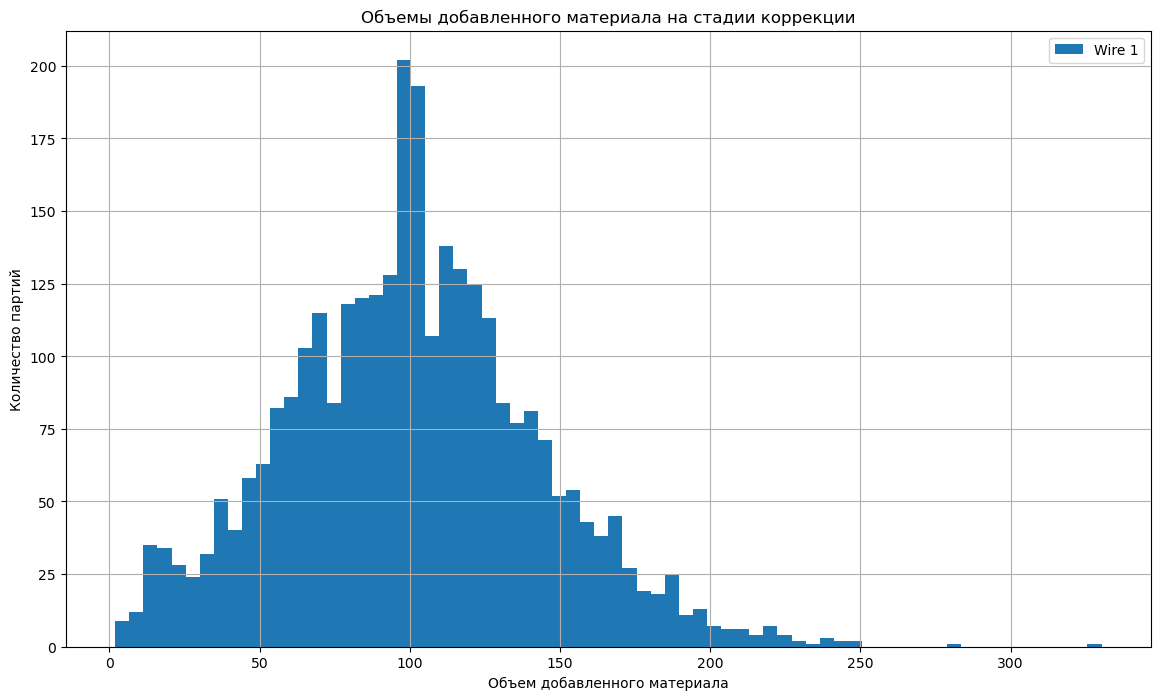

In [26]:
visual(wire['Wire 1'])

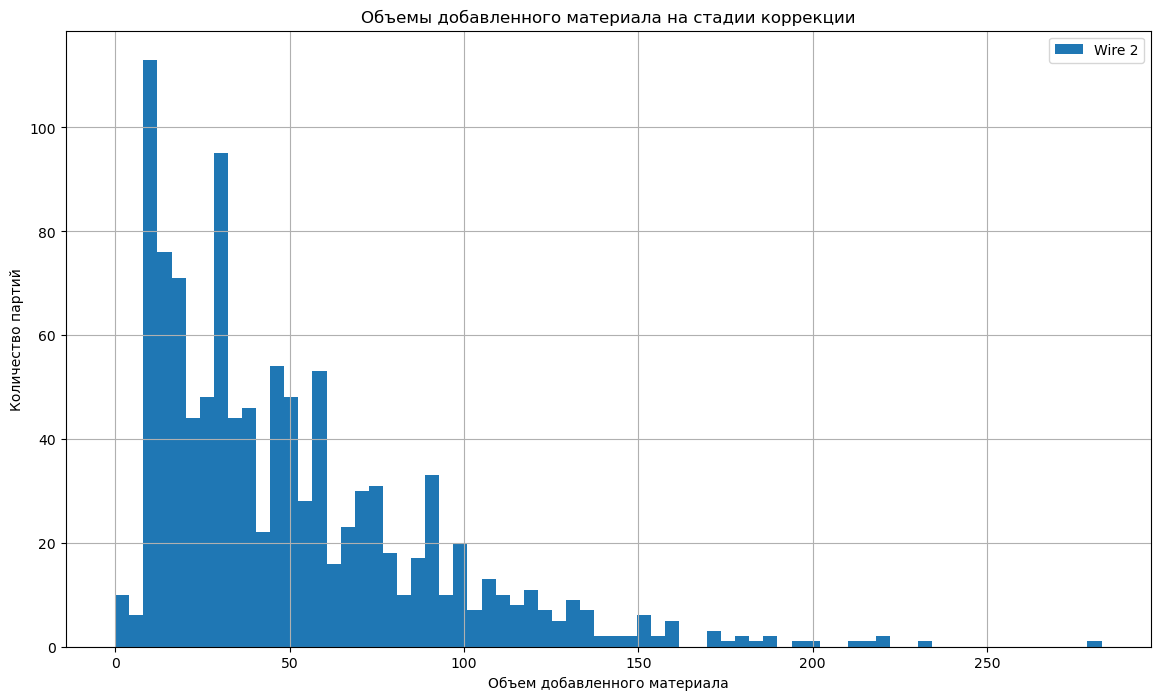

In [27]:
visual(wire['Wire 2'])

**Первого типа проволоки добавляется всегда больше, чем второго. Пик для 1 типа - около 100ед. Для второго типа - около 10 и около 30 ед.**

**Явных выбросов не выявлено.**  

## 5. data_wire_time_new.csv

In [28]:
wire_time

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-09-06 11:33:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-09-06 12:18:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-06 14:36:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-06 15:33:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [30]:
wire_time.duplicated().sum()

0

Аналогично таблице wire, в данном фрейме данных находятся сведения о подаче проволоки.

Столбцы `Wire 1-9` перечисляют дату и время, в которое проволока была добавлена в смесь.

Значения `NaN` - данный тип проволоки не добавлялся в смесь.

Визуально и с помощью метода **.info** таблицы `wire` и `wire_time` совпадают. **Аномалий/особенностей не выявлено.**

## 6. data_gas_new.csv

In [31]:
gas

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом.

В данном датафрейме мы видим количество газа, которое потребовалось для продувки сплава определенной партии.

In [32]:
gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


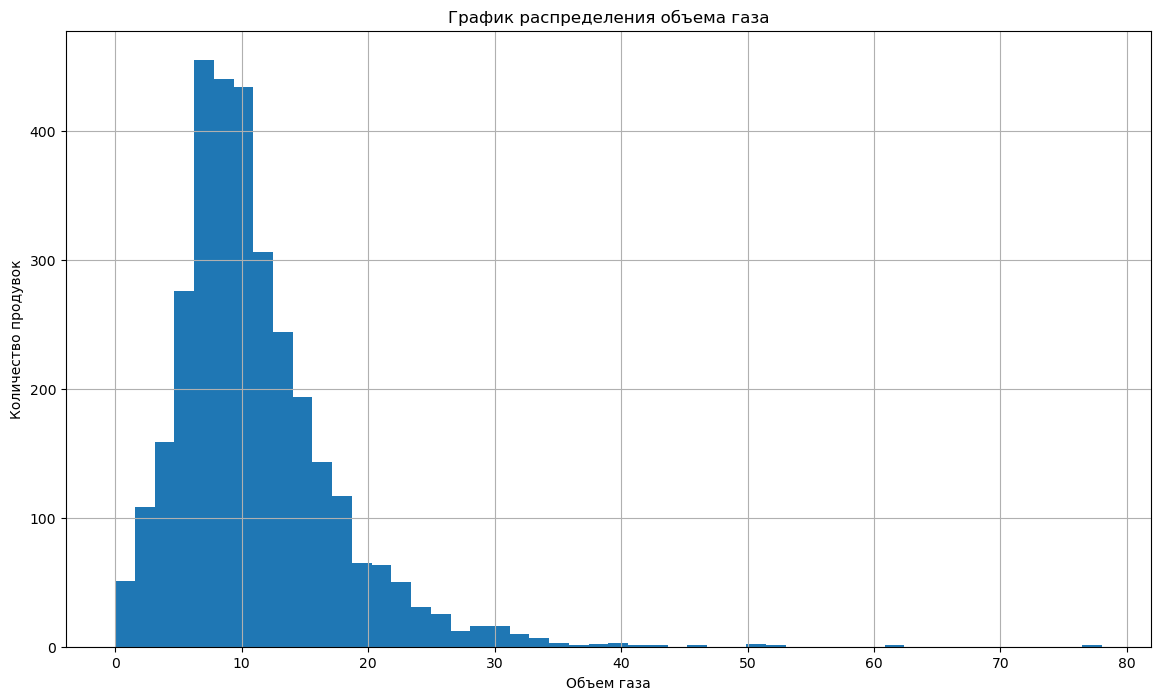

In [33]:
gas['Газ 1'].hist(bins=50, figsize=(14,8));
plt.xlabel('Объем газа');
plt.ylabel('Количество продувок');
plt.title('График распределения объема газа');

**В данных имеются выбросы, так как нормальное распределение объема газа для продувки колеблется в пределах от 0 до 30.**

Также количество продувок не соответствует количеству партий. Убедимся, что некоторые партии продувались по несколько раз, либо поймем, что имеет дело с дубликатами.

In [34]:
gas['key'].duplicated().sum()

0

**Помимо аномальных значений, других особенностей в данных не выявлено.**

In [35]:
gas['key'].nunique()

3239

**ИНТЕРЕСНОЕ ЗАМЕЧАНИЕ** 

В каждом фрейме данных представлено разное количество партий. Это может быть связано с многими факторами (это может быть ошибка при формировании выборки, либо брак, отсеивающийся на определенном этапе, либо идеальный сплав стали, не требующий доработок).

Зададим вопрос по данной ситуации заказчику.

## 7. data_temp_new.csv

In [36]:
temp

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


In [37]:
temp['key'].nunique()

3216

После обработки газом, сплав перемешивают и проводят повторные измерения температуры. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Соответственно в данном фрейме данных будут дубликаты в столбце `key`, которые будут означать лишь очередную итерацию обработки.

В столбце `Время замера` указывается дата и время замера температуры сплава.

В столбце `Температура` указывается результат измерений температуры.

In [38]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


В данном файле нам представлено 18 092 измерений, для каждого указаны дата и время, но имеется существенное количество пропусков в столбце `Температура`. Лучше уточнить их причину у заказчика.

In [39]:
temp.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


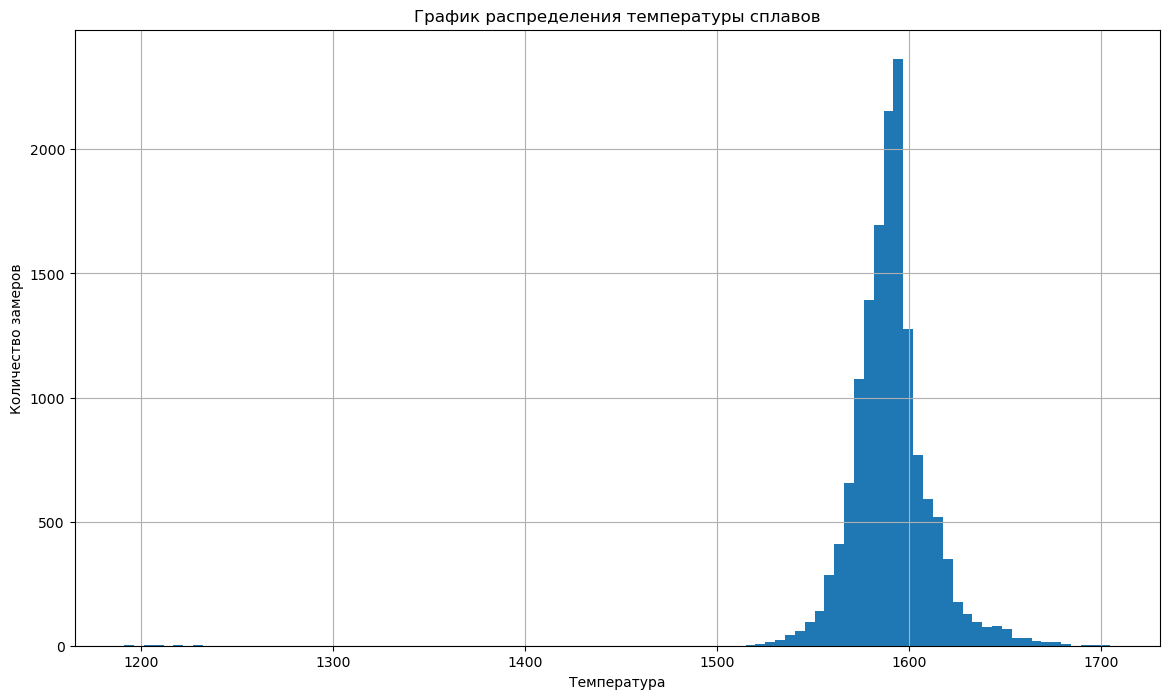

In [40]:
temp['Температура'].hist(bins=100, figsize=(14,8));
plt.xlabel('Температура');
plt.ylabel('Количество замеров');
plt.title('График распределения температуры сплавов');

Распределение выглядит нормальным. **Имеются слишком низкие для плавки стали значения измерений температуры.**

## Вывод по первичному анализу данных.

1. В данных об электродах присутствуют аномально низкие значения. При предобработке получится заменить их самостоятельно, взяв среднее значение по выборке.


2. В данных о проволочных и сыпучих материалах также имеется некоторое количество аномальных значений, которые потребуется обработать. 


3. В каждом фрейме данных представлено разное количество партий. Это может быть связано с многими факторами (это может быть ошибка при формировании выборки, либо брак, отсеивающийся на определенном этапе, либо идеальный сплав стали, не требующий доработок).


4. В файле **data_temp_new.csv** нам представлено 18 092 измерений, для каждого указаны дата и время, но имеется существенное количество пропусков в столбце `Температура`. Также в присутствующих данных присутствуют аномальные значения, требующие обработки.


В остальном данные информативны. После беседы с заказчиком можно будет устранить некоторые недочеты, а также выявить (если будут) иные. 

## План проекта:
1. Провести предобработку данных
2. Создать общую выборку, проверить ее на мультиколлинеарность. Разделить общую выборку на тренировочную и тестовую. Выделить признаки, целевой признак.
3. Опробовать несколько моделей, провести кросс-валидацию. Определить модель, которая выдаст лучшие показатели метрики `MAE`.
4. Протестировать лучшую модель на тестовой выборке
5. Проверить модель на адекватность
6. Провести анализ важности факторов у лучшей модели 
7. Написать общий вывод по проекту

# Предобработка данных

Работать с данными будем в том же порядке, в котором проводили первичный анализ. Помимо работы с аномалиями и пропусками на этом шаге будем генерировать новые необходимые признаки.  

## 1. arc

Для начала удалим очевидный выброс в данных. Еще раз взглянем на него. 

Аномально низкое значение реактивной мощности: -715.479924


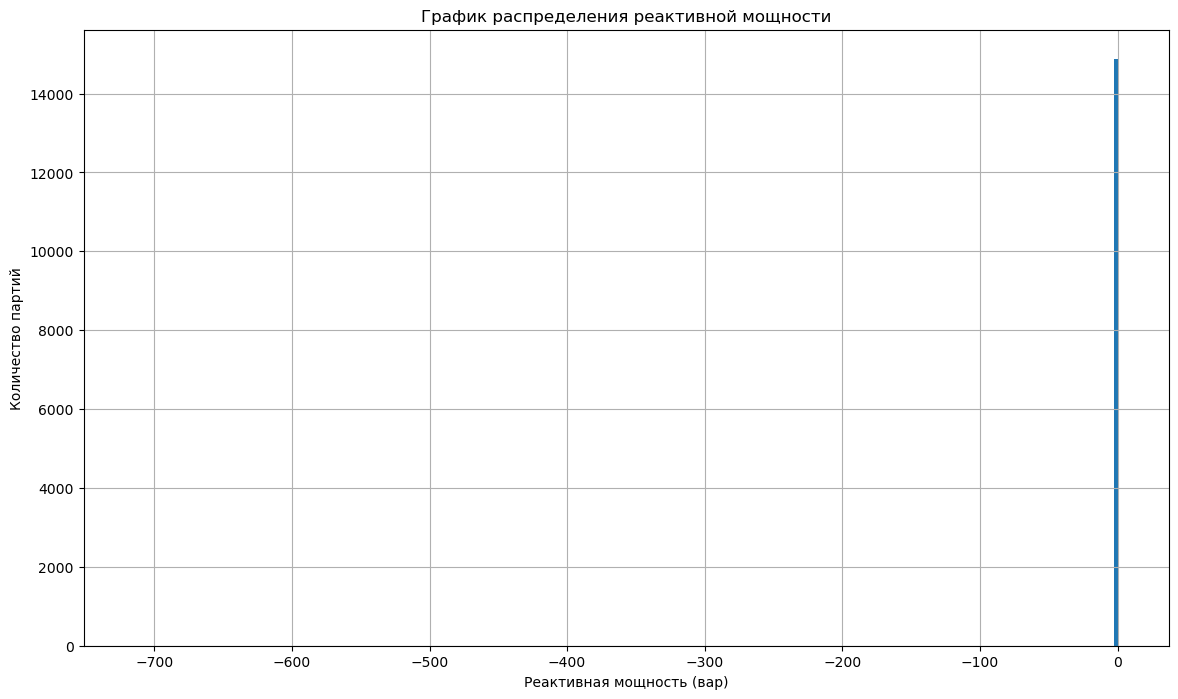

In [41]:
arc['Реактивная мощность'].hist(figsize=(14,8), bins=200);
plt.xlabel('Реактивная мощность (вар)');
plt.ylabel('Количество партий');
plt.title('График распределения реактивной мощности');
print('Аномально низкое значение реактивной мощности:', arc['Реактивная мощность'].describe()['min'])

In [42]:
arc['Реактивная мощность'].sort_values()

9780    -715.479924
709        0.153777
3290       0.153921
11794      0.155221
6130       0.156525
            ...    
8963       1.214912
14115      1.222632
8116       1.223063
3452       1.258628
2591       1.270284
Name: Реактивная мощность, Length: 14876, dtype: float64

Удаляем найденную строку.

In [43]:
arc = arc.drop(9780, axis=0)

Для дальнейшей работы нам требуется найти полную мощность. Это облегчит обучение модели и улучшит метрику качества. Создадим отдельный столбец, в котором вычислим полную мощность для каждого нагрева. 

In [44]:
arc['Полная мощность'] = (arc['Активная мощность']**2 + arc['Реактивная мощность']**2)**0.5

In [45]:
arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934


Отлично. Следующим шагом нам нужно агрегировать по ключу полную мощность.

In [46]:
power = arc.groupby('key', as_index=False).agg({'Полная мощность':'sum'})

In [47]:
power

,key,Полная мощность
0,1,3.718736
1,2,2.588349
2,3,5.019223
3,4,3.400038
4,5,2.816980
...,...,...
3209,3237,3.250657
3210,3238,1.723937
3211,3239,6.014480
3212,3240,4.082920


Мы получили готовую таблицу, данные которой будут использоваться в обучении модели.

## 2. bulk

Первым делом избавимся от пропущенных значений, заменив их на 0.

In [48]:
bulk = bulk.fillna(0)

In [49]:
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 2   3129 non-null   float64
 3   Bulk 3   3129 non-null   float64
 4   Bulk 4   3129 non-null   float64
 5   Bulk 5   3129 non-null   float64
 6   Bulk 6   3129 non-null   float64
 7   Bulk 7   3129 non-null   float64
 8   Bulk 8   3129 non-null   float64
 9   Bulk 9   3129 non-null   float64
 10  Bulk 10  3129 non-null   float64
 11  Bulk 11  3129 non-null   float64
 12  Bulk 12  3129 non-null   float64
 13  Bulk 13  3129 non-null   float64
 14  Bulk 14  3129 non-null   float64
 15  Bulk 15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Исходя из первичного анализа, для 2, 5, 7, 8, 9, 10, 11, 13 материала количество объектов менее 200. Данные столбцы можно сгруппировать в один признак и назвать его `Another_bulk`. 

In [50]:
bulk['Another_bulk'] = bulk['Bulk 2'] + bulk['Bulk 5'] + bulk['Bulk 7'] + bulk['Bulk 8'] + bulk['Bulk 9'] + bulk['Bulk 10'] + bulk['Bulk 11'] + bulk['Bulk 13']
bulk = bulk.drop(['Bulk 2', 'Bulk 5', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 13'], axis=1)

In [51]:
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           3129 non-null   int64  
 1   Bulk 1        3129 non-null   float64
 2   Bulk 3        3129 non-null   float64
 3   Bulk 4        3129 non-null   float64
 4   Bulk 6        3129 non-null   float64
 5   Bulk 12       3129 non-null   float64
 6   Bulk 14       3129 non-null   float64
 7   Bulk 15       3129 non-null   float64
 8   Another_bulk  3129 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 220.1 KB


Признаков стало меньше, а информативность данных осталась на прежнем уровне.

## 3. wire

Для проволочных материалов проведем такую же предобработку, как для сыпучих. 

In [52]:
wire = wire.fillna(0)

In [53]:
wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
 3   Wire 3  3081 non-null   float64
 4   Wire 4  3081 non-null   float64
 5   Wire 5  3081 non-null   float64
 6   Wire 6  3081 non-null   float64
 7   Wire 7  3081 non-null   float64
 8   Wire 8  3081 non-null   float64
 9   Wire 9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Исходя из первичного анализа, для 3, 4, 5, 6, 7, 8, 9 материала количество объектов менее 100. Данные столбцы можно сгруппировать в один признак и назвать его `Another_wire`.

In [54]:
wire['Another_wire'] = wire['Wire 3'] + wire['Wire 4'] + wire['Wire 5'] + wire['Wire 6'] + wire['Wire 7'] + wire['Wire 8'] + wire['Wire 9'] 
wire = wire.drop(['Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'], axis=1)

In [55]:
wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           3081 non-null   int64  
 1   Wire 1        3081 non-null   float64
 2   Wire 2        3081 non-null   float64
 3   Another_wire  3081 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 96.4 KB


## 4. temp (целевой признак) 

Температура, указанная в данном датафрейме является целевым признаком в нашем проекте. Конкретнее - финальная температура. В результате первичного анализа нами было выявлено большое количество пропущенных значений в данных. После диалога с заказчиком оказалось, что дополнить данные не представляется возможным. Удалим все наблюдения по объекту, где отсутствует целевой признак.

In [56]:
temp['Время замера'] = pd.to_datetime(temp['Время замера'])

In [57]:
final_time = temp.groupby('key', as_index=False)['Время замера'].max()
final_time = pd.DataFrame(final_time)
final_time

,key,Время замера
0,1,2019-05-03 11:30:38
1,2,2019-05-03 11:55:09
2,3,2019-05-03 12:35:57
3,4,2019-05-03 12:59:47
4,5,2019-05-03 13:36:39
...,...,...
3211,3237,2019-09-06 11:55:45
3212,3238,2019-09-06 12:34:37
3213,3239,2019-09-06 15:09:55
3214,3240,2019-09-06 16:35:26


Также выдеилим начальную температуру, перед итерациями нагрева и общую длительность нагрева, как доп признаки.

In [58]:
start_time = temp.groupby('key', as_index=False)['Время замера'].min()
start_temp = pd.DataFrame(start_time)
start_temp = start_temp.merge(temp)
start_temp = start_temp.drop('Время замера', axis=1)
start_temp = start_temp.rename(columns = {'Температура':'Начальная температура'})
start_temp

,key,Начальная температура
0,1,1571.0
1,2,1581.0
2,3,1596.0
3,4,1601.0
4,5,1576.0
...,...,...
3211,3237,1569.0
3212,3238,1584.0
3213,3239,1598.0
3214,3240,1617.0


In [59]:
start_temp['Длительность нагрева'] = (final_time['Время замера']) - (start_time['Время замера'])
start_temp

,key,Начальная температура,Длительность нагрева
0,1,1571.0,0 days 00:28:34
1,2,1581.0,0 days 00:21:05
2,3,1596.0,0 days 00:29:13
3,4,1601.0,0 days 00:20:20
4,5,1576.0,0 days 00:25:36
...,...,...,...
3211,3237,1569.0,0 days 00:24:30
3212,3238,1584.0,0 days 00:18:22
3213,3239,1598.0,0 days 00:53:05
3214,3240,1617.0,0 days 01:10:05


Переведем время в секунды.

In [60]:
for i in range(len(start_temp['Длительность нагрева'])):
    start_temp['Длительность нагрева'][i] = start_temp['Длительность нагрева'][i].total_seconds() 

Создадим общую таблицу с выделенными нами признаками.

In [61]:
final_time = final_time.merge(temp)
final_time = final_time.merge(start_temp)

In [62]:
final_time

,key,Время замера,Температура,Начальная температура,Длительность нагрева
0,1,2019-05-03 11:30:38,1613.0,1571.0,1714.0
1,2,2019-05-03 11:55:09,1602.0,1581.0,1265.0
2,3,2019-05-03 12:35:57,1599.0,1596.0,1753.0
3,4,2019-05-03 12:59:47,1625.0,1601.0,1220.0
4,5,2019-05-03 13:36:39,1602.0,1576.0,1536.0
...,...,...,...,...,...
3211,3237,2019-09-06 11:55:45,NaN,1569.0,1470.0
3212,3238,2019-09-06 12:34:37,NaN,1584.0,1102.0
3213,3239,2019-09-06 15:09:55,NaN,1598.0,3185.0
3214,3240,2019-09-06 16:35:26,NaN,1617.0,4205.0


In [63]:
final_time.isna().sum()

key                        0
Время замера               0
Температура              739
Начальная температура      0
Длительность нагрева       0
dtype: int64

Мы получили таблицу, в которой отображается финальная температура, то есть нужный нам целевой признак. Теперь удалим объекты с отсутствующим значением.

In [64]:
final_time = final_time.dropna()

In [65]:
final_temp = final_time[['key', 'Длительность нагрева', 'Начальная температура','Температура']]

In [66]:
final_temp['Длительность нагрева'] = final_temp['Длительность нагрева'].astype(int)

Проверим новые данные на выбросы.

In [67]:
final_temp['Длительность нагрева'].describe()

count     2477.000000
mean      2279.054905
std       1374.678745
min          0.000000
25%       1541.000000
50%       2007.000000
75%       2738.000000
max      23674.000000
Name: Длительность нагрева, dtype: float64

In [68]:
final_temp['Длительность нагрева'].sort_values(ascending=False).head(15)

1674    23674
2091    21331
1943    19409
632     17467
629     13408
789     12895
1866    12778
43      12323
1865    11887
1498    11692
41      10976
115     10319
2090     8900
630      8667
1986     8635
Name: Длительность нагрева, dtype: int32

Аномальных значений не так много и, скорее всего, они связаны с особенностями проивзодства.

In [69]:
final_temp

,key,Длительность нагрева,Начальная температура,Температура
0,1,1714,1571.0,1613.0
1,2,1265,1581.0,1602.0
2,3,1753,1596.0,1599.0
3,4,1220,1601.0,1625.0
4,5,1536,1576.0,1602.0
...,...,...,...,...
2472,2495,1380,1570.0,1591.0
2473,2496,1705,1554.0,1591.0
2474,2497,962,1571.0,1589.0
2475,2498,1520,1591.0,1594.0


В данную таблицу мы вместили 2 новых важных признака, а также целевой признак. **Все данные без пропусков, можно приступать к созданию общей выборки.**

# Создание общей выборки 

В качестве признаков мы выбрали те самые данные, которые предобрабатывали выше. Объединим их в один датафрейм.

In [70]:
general_data = final_temp.merge(power, on='key')

In [71]:
general_data = general_data.merge(bulk, on='key')

In [72]:
general_data = general_data.merge(wire, on='key')

In [73]:
general_data = general_data.merge(gas, on='key')

In [74]:
general_data = general_data.drop('key', axis=1)

In [75]:
general_data.head()

,Длительность нагрева,Начальная температура,Температура,Полная мощность,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Another_bulk,Wire 1,Wire 2,Another_wire,Газ 1
0,1714,1571.0,1613.0,3.718736,0.0,0.0,43.0,0.0,206.0,150.0,154.0,0.0,60.059998,0.00000,0.0,29.749986
1,1265,1581.0,1602.0,2.588349,0.0,0.0,73.0,0.0,206.0,149.0,154.0,0.0,96.052315,0.00000,0.0,12.555561
2,1753,1596.0,1599.0,5.019223,0.0,0.0,34.0,0.0,205.0,152.0,153.0,0.0,91.160157,0.00000,0.0,28.554793
3,1220,1601.0,1625.0,3.400038,0.0,0.0,81.0,0.0,207.0,153.0,154.0,0.0,89.063515,0.00000,0.0,18.841219
4,1536,1576.0,1602.0,2.816980,0.0,0.0,78.0,0.0,203.0,151.0,152.0,0.0,89.238236,9.11456,0.0,5.413692


In [76]:
general_data.shape

(2329, 16)

**Так выглядит датафрейм, с которым далее будем работать.** Проверим данные на мультиколлинеарность. 

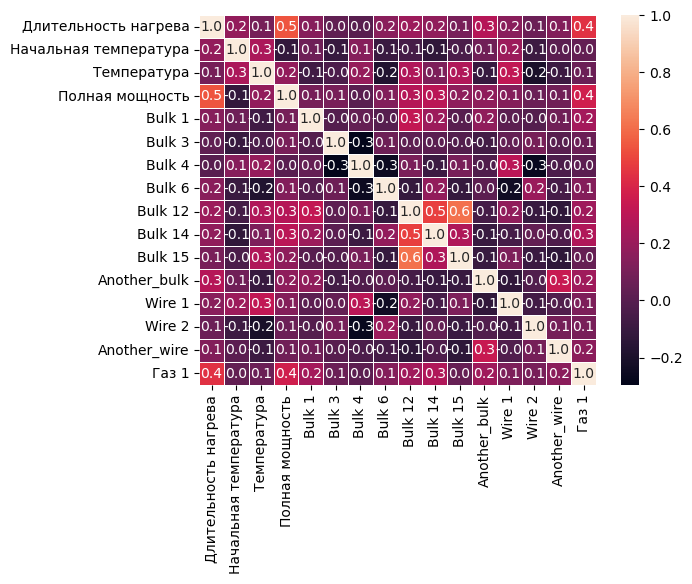

In [77]:
sns.heatmap(general_data.corr(), annot=True, fmt=".1f", linewidths=.5);

Судя по тепловой карте, сильнее всего на финальную температуру влияют некоторые виды добавляемых материалов, а также в некоторой степени полная мощность. Сильной зависимости не выявлено.

1. Чем больше длительность нагрева, тем больше затрачивается мощности
2. Чем больше длительность нагрева, тем больше затрачивается газа
3. Чем больше затрачивается мощности, больше требуется газа

## Подотовка выборок для обучения моделей 

In [78]:
#  Разделение на признаки (X) и целевую переменную (y)

X = general_data.drop(['Температура'], axis=1)
y = general_data['Температура']

In [79]:
#  Разделение данных на обучающую и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=61023)

print(X.shape)
print(y.shape)
print()
print('Размеры обучающей выборки:')
print(X_train.shape)
print(y_train.shape)
print()
print('Размеры тестовой выборки:')
print(X_test.shape)
print(y_test.shape)

(2329, 15)
(2329,)

Размеры обучающей выборки:
(1746, 15)
(1746,)

Размеры тестовой выборки:
(583, 15)
(583,)


# Обучение моделей

**Проводить проверку качества моделей будем с помощью кросс-валидации по метрике `MAE`.**

In [80]:
# создадим функцию, которая будет подбирать гиперпараметры для указанной ей модели

def parameters(model_name, params, features, target):
    model = model_name
    parametrs = params    
    grid = GridSearchCV(model, parametrs) 
    grid.fit(features, target)    
    print('лучшие параметры:', grid.best_estimator_)

In [81]:
# и еще одну функцию, которая проведет кросс-валидацию

def score (model_name, features, target):
    model = model_name
    model.fit(features, target)
    print('MAE модели:', min(-cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')))

In [82]:
# для начала рассмотрим модель линейной регрессии

score (LinearRegression(), X_train, y_train)

MAE модели: 6.733441456956701


In [83]:
# Теперь модель дерева решений

parameters(DecisionTreeRegressor(random_state=61023),{'max_depth': range (1, 13, 1),
                               'min_samples_leaf': range (1, 11, 1)}, 
                                X_train, y_train)

лучшие параметры: DecisionTreeRegressor(max_depth=4, min_samples_leaf=7, random_state=61023)


In [84]:
score (DecisionTreeRegressor(max_depth=4, min_samples_leaf=7, random_state=61023), X_train, y_train)

MAE модели: 7.292027408678272


In [85]:
# и случайный лес 

parameters(RandomForestRegressor(random_state=61023),{'max_depth': range (5, 10, 1),                          
                         'n_estimators': range (50, 100, 10)}, 
                          X_train, y_train)

лучшие параметры: RandomForestRegressor(max_depth=9, n_estimators=70, random_state=61023)


In [86]:
score (RandomForestRegressor(max_depth=9, n_estimators=70, random_state=61023), X_train, y_train)

MAE модели: 6.555795869054089


Используем библиотеку LightGBM и её средствами построим модель градиентного бустинга.

In [87]:
parameters(LGBMRegressor(random_state=61023, verbose=-1),{'max_depth': range (1, 10, 1),
                                         'n_estimators': range (30, 70, 1)},
                                          X_train, y_train)

лучшие параметры: LGBMRegressor(max_depth=5, n_estimators=68, random_state=61023, verbose=-1)


In [88]:
score (LGBMRegressor(max_depth=5, n_estimators=68, random_state=61023, verbose=-1), X_train, y_train)

MAE модели: 6.368854670938561


**Лучшей моделью оказалась LGBMRegressor(max_depth=5, n_estimators=68, random_state=61023, verbose=-1)**. Проверим ее на тестовой выборке.

# Тестирование модели

In [89]:
model = LGBMRegressor(max_depth=3, n_estimators=68, random_state=61023, verbose=-1)
model.fit(X_train, y_train)

pred = model.predict(X_test)
result = mean_absolute_error(y_test, pred)
result

6.799802127940957

**Вручную подобрав самые лучшие параметры, отталкиваясь от найденных, получилось добиться метрики MAE равной 6.79.** Теперь нужно проверить модель на адекватность, а также провести анализ важности факторов.

In [90]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)

predict_for_check1 = dummy_regr.predict(X_test)
result = mean_absolute_error(y_test, predict_for_check1)
result

8.201746113144662

**Наша модель прошла проверку на адекватность, ее показатели намного лучше, чем у константной модели.** 

# Анализ важности факторов

In [91]:
# Напишем функцию для визуализации важности признаков в порядке убывания

def plotImp(model, X , num = 15, fig_size = (50, 20)):
    feature_imp = pd.DataFrame({'Значение':model.feature_importances_,'Признак':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Значение", y="Признак", data=feature_imp.sort_values(by="Значение",
                                                        ascending=False)[0:num])
    plt.title('Важность признаков')
    plt.show()

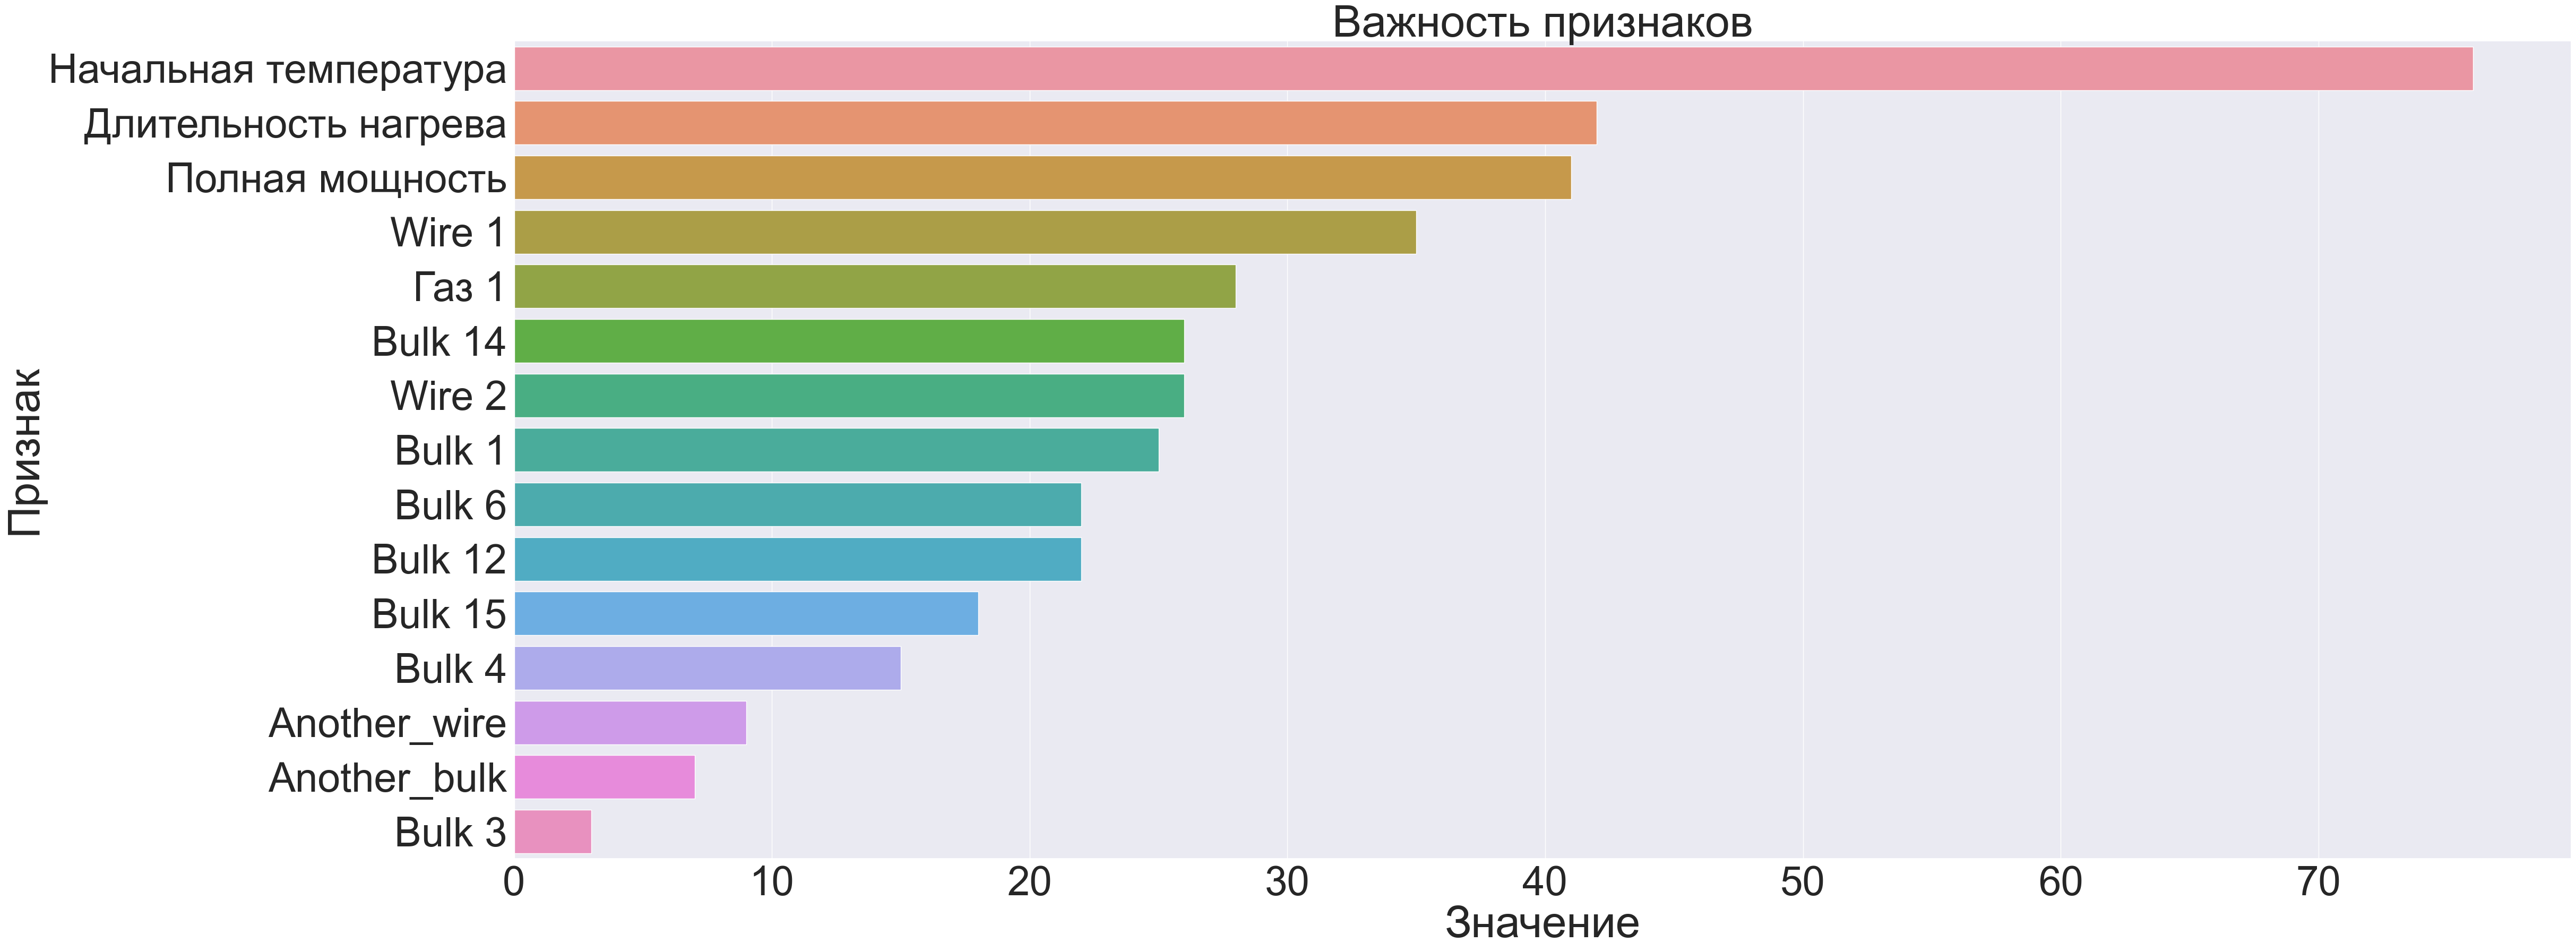

In [92]:
plotImp(model, X)

# Отчёт

### Все пункты плана были выполнены.

1. Провести предобработку данных
    1. Сначала был проведен первичный анализ данных, который позволил ознакомиться с информацией, которую нам предоставили.
        1. В данных об электродах присутствуют аномально низкие значения. 
        2. В данных о проволочных и сыпучих материалах также имеется некоторое количество аномальных значений
        3. В каждом фрейме данных представлено разное количество партий. Это может быть связано с многими факторами (это может быть ошибка при формировании выборки, либо брак, отсеивающийся на определенном этапе, либо идеальный сплав стали, не требующий доработок)
        4. В файле ***data_temp_new.csv*** нам представлено 18 092 измерений, для каждого указаны дата и время, но имеется существенное количество пропусков в столбце `Температура`. Так как это целевой признак для обучения модели - от большой части драгоценных данных придется отказаться.
    2. Затем была проведена предобработка данных.    
        1. Был удалён единственный выброс в столбце `Реактивная мощность` файла ***data_arc_new.csv***.
        2. Был добавлен признак `Полная мощность`, содержащий полную мощность, затраченную на нагрев сплава, вычисленную по формуле.
        3. В файле ***data_bulk_new*** пропуски были заполнены значением **0**
        4. В файле ***data_bulk_new*** были удалены столбцы с типами материалов, которые добавлялись менее 200 раз.
        5. Был добавлен признак `Another_bulk`, включающий в себя объем всех материалов, столбцы с которыми были удалены.
        6. В файле ***data_wire_new*** пропуски были заполнены значением **0**
        7. В файле ***data_wire_new*** были удалены столбцы с типами материалов, которые добавлялись менее 100 раз.
        8. Был добавлен признак `Another_wire`, включающий в себя объем всех материалов, столбцы с которыми были удалены.
        9. Был добавлен признак `Длительность нагрева`, содержащий время от начала до конца нагрева сплава в секундах.
        10. Был добавлен признак `Начальная температура`, содержащий температуру сплава до итераций нагрева.
        11. Был добавлен **целевой признак** `Температура`, содержащий финальную температуру сплава.
        
        
2. Создать общую выборку, проверить ее на мультиколлинеарность. Разделить общую выборку на тренировочную и тестовую. Выделить признаки, целевой признак.
    1. Все необходимые признаки и целевой признак были объединены в один датафрейм.
    2. Была произведена проверка общей выборки на мультиколлинеарность.
        1. Судя по тепловой карте, сильнее всего на финальную температуру влияют некоторые виды добавляемых материалов, а также в некоторой степени полная мощность. Сильной зависимости не выявлено. Из очевидных выводов: Чем больше длительность нагрева, тем больше затрачивается мощности. Чем больше длительность нагрева, тем больше затрачивается газа. Чем больше затрачивается мощности, больше требуется газа.
    3. Была произведена подотовка выборок для обучения моделей (test_size=0.25).         


3. Опробовать несколько моделей, провести кросс-валидацию. Определить модель, которая выдаст лучшие показатели метрики MAE.
    1. Была произведена проверка 4-ех моделей. После подбора гиперпараметров и проведения кросс-валидации по метрике **MAE** результаты оказались следующими:
        1. LinearRegression() - MAE модели: 6.733441456956685
        2. DecisionTreeRegressor(max_depth=4, min_samples_leaf=7, random_state=61023) - MAE модели: 7.292027408678272
        3. RandomForestRegressor(max_depth=9, n_estimators=60, random_state=61023) - MAE модели: 6.555795869054089
        4. LGBMRegressor(max_depth=5, n_estimators=68, random_state=61023) - MAE модели: 6.368854670938561
    2. Была определена лучшая модель. Ею оказалась **LGBMRegressor(max_depth=5, n_estimators=68, random_state=61023**.
    
    
4. Протестировать лучшую модель на тестовой выборке
    1. **Вручную подобрав самые лучшие гиперпараметры для выбранной модели, отталкиваясь от найденных при кросс-валидации, получилось добиться метрики MAE равной 6.79**. 
    
5. Проверить модель на адекватность
    1. Была проведена проверка модели на адекватность. 
        1. МАЕ константной модели - 8.201746113144662
        2. МАЕ нашей модели - 6.799802127940957

6. Провести анализ важности факторов у лучшей модели
    1. Был проведен анализ важности факторов у выбранной модели. **Факторы в порядке убывания важности:**
       - Начальная температура
       - Длительность нагрева
       - Полная мощность
       - Wire 1
       - Газ 1
       - Wire 2
       - Bulk 14
       - Bulk 1
       - Bulk 6
       - Bulk 12
       - Bulk 15
       - Bulk 4
       - Another_wire (все оставшиеся типы проволоки)
       - Another_bulk (все оставшиеся типы сыпучих материалов)
       - Bulk 3




### Трудности во время выполнения работы

1. **Мало теоретической информации.** Для полного понимания исследования требуется много времени самостоятельно изучать данные, но даже после их изучения остаётся много вопросов. Какие допустимые значения для минимальных и максимальных границ температуры/объема добавленых присадок? Один и тот же газ ли использовался на протяжении работы со сплавами, представленными в выгрузке? И так далее. Выходом из ситуации стало игнорирование данных факторов. Но, зная ответы на вопросы, можно достаточно сильно улучшить финальную модель.
2. **Лишние данные.** В предоставленных файлах, пара ***data_bulk_time_new.csv*** и ***data_wire_time_new.csv*** не имели никакой важности. Было затрачено лишнее время на их анализ, а также лишние человеческие ресурсы для их выгрузки. 
3. **Важнейшее замечание - мало данных для обучения модели**. Изначально, до предобработки данных, в важнейшем файле ***data_temp_new.csv*** были данные для **3216** партий. Из-за большого количества пропущенных значений финальной температуры, осталось только **2477**, а после объединения всех признаков в общую выборку - **2329**. Из-за таких потерь данных, обучить модель для качественной работы проблематично. Выходом из ситуации стало добавление многих новых признаков и ручной добор гиперпараметров для финальной модели. 



### Ключевые шаги в решении задачи
1. Добавление признаков:
- Полная мощность
- Длительность нагрева
- Начальная температура
2. Кросс-валидация
3. Перебор разных моделей 
4. Ручной доподбор гиперпараметров лучшей модели, найденных GridSearchCV


### ИТОГОВАЯ МОДЕЛЬ
3. Итоговой моделью стала `LGBMRegressor(max_depth=3, n_estimators=68, random_state=61023)`. Показатель метрики MAE -  **6.79**.
- Список признаков, указанных выше, был подобран на основе многих итераций обучения и тестирования модели
- Гиперпараметры для модели были подобраны с помощью `GridSearchCV` и вручную отредактированы для максимально хорошего результата.

### Мои рекомендации для улучшения модели
1. **Увеличить общее количество выгружаемых данных**, избегать пропусков в файле с температурой (нашим целевым признаком)
2. Исключить неинформативные данные
3. Добавить больше данных, которые влияют на финальную температуру сплава (если таковые имеются)
4. Добавить больше теоретического материала, поясняющего принцип производства